# State-level Covid-19 Analysis for United States

This notebook utilizes [data kindly made available](https://github.com/CSSEGISandData/COVID-19) by the [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://systems.jhu.edu/) at and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.   

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [1]:
# A week, A month, two weeks out ...
1.25**7, 1.25**31, 1.15*14

(4.76837158203125, 1009.7419586828951, 16.099999999999998)

In [2]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [3]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%m/%d/%y"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

In [4]:
def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)


def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [5]:
# Tools specific to the notebook analysis

def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(ts.extract(region).tail(7+prev).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(ts.extract(region).tail(7, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    proj.tail(dist).show()
    proj.select(['date', region, 'new']).tail(prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=6)
    plots.plot([end, end], [0, combined[region][-1]])
    pname = make_pname(region, prev)
    plots.plot([pend, pend], [0, combined[pname][-1]])
    plots.text(end, combined[region][-dist], "{:,}".format(int(combined[region][-dist])))
    plots.text(end, combined[region][-1], "{:,}".format(int(combined[region][-1])))
    plots.text(pend, combined[region][-dist-prev], "{:,}".format(int(combined[region][-dist-prev])))
    plots.text(pend, combined[pname][-1], "{:,}".format(int(combined[pname][-1])))
    combined.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))
    _ = plots.xticks(rotation=90)
    
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if 'rate' in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [6]:
def exp_rate(days, s, r):
    return [s*r**day for day in days]

def lin_rate(days, s, r):
    return [s + r*day for day in days]

def fit(model, trend):
    """Fit a 2 paramater model to a rate trend"""
    try :
        doffs = list(range(trend.num_rows))
        params, pcov = scipy.optimize.curve_fit(model, doffs, trend['rate'])
        return params, np.sqrt(np.diag(pcov))
    except :
        return [np.nan, np.nan], [np.nan, np.nan]

def model_rate_trend(trend):
    eparams, epcov = fit(exp_rate, trend)
    doffs = list(range(trend.num_rows))
    t1 = trend.with_column('exp pred', exp_rate(doffs, eparams[0], eparams[1]))
    lparams, lpcov = fit(lin_rate, trend)
    t2 = t1.with_column('lin pred', lin_rate(doffs, lparams[0], lparams[1]))
    return t2, eparams, lparams

def show_model_rate_trend(trend):
    mtrend, eparams, lparams = model_rate_trend(trend)
    print(eparams, lparams)
    mtrend.extract(['exp pred', 'lin pred']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    mtrend.plots[-1].scatter(mtrend['date'], mtrend['rate'])
    mtrend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

In [7]:
# Daily growth rates

def wgmean(vals):
    xvals = [x for x in vals if np.isfinite(x)]
    try :
        return scipy.stats.gmean(xvals) if xvals else np.nan
    except :
        return np.nan

def growth_rate(trend, window=3):
    """Smooth raw rates"""
    rates = trend['rate']
    vals = np.array((window-1)*[np.nan] + list(rates))
    return [wgmean(vals[i:i+window]) for i in range(len(rates))]

def plot_rate_trend(trend):
    trend = trend.with_column('gm_rate', growth_rate(trend))
    trend.extract(['gm_rate']).oplot(width=8)
    trend.plots[-1].scatter(trend['date'], trend['rate'])
    trend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [8]:
stateCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv" 
stateDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv" 

In [9]:
raw_states_cases = Table.read_table(stateCasesURL)
raw_states_deaths = Table.read_table(stateDeathsURL)

In [10]:
states_population = raw_states_deaths.select(['Province_State', 'Population']).group('Province_State', sum)
states_population.relabel('Population sum', 'Population')
states_population.relabel('Province_State', 'State')

State,Population
Alabama,4903185
Alaska,731545
American Samoa,55641
Arizona,7278717
Arkansas,3017804
California,39512223
Colorado,5758736
Connecticut,3565287
Delaware,973764
Diamond Princess,0


In [11]:
def population(state):
    return states_population.where('State', state)['Population'][0]

In [12]:
def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2',
                           'Country_Region', 'Lat','Long_', 'Combined_Key']).group('Province_State', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Population',
                           'Country_Region', 'Lat','Long_', 'Combined_Key']).group('Province_State', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

In [13]:
cases_by_state = by_state_cases(raw_states_cases)
deaths_by_state = by_state_deaths(raw_states_deaths)

cases = TimeTable.transpose(cases_by_state, 'Province_State', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_state, 'Province_State', time_col='date', time_less = less_day, time_inc = inc_day)
states = cases.categories

In [14]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'04/19/20'

In [15]:
# Number of states/regions reported
len(states)

58

## US National picture

The following graph shows the national picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

Text(04/19/20, 26889.0, '26,889')

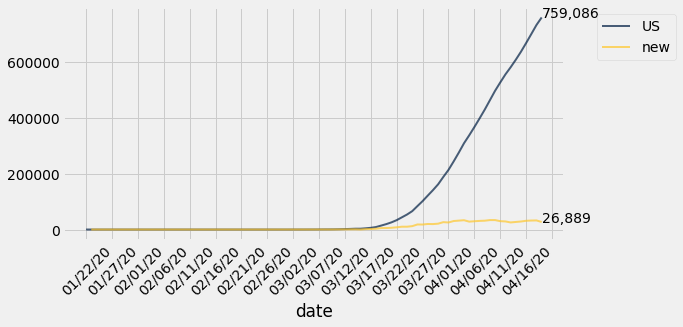

In [16]:
US_cases = cases.select(cases.time_column)
US_cases['US'] = cases.sum_cols()

US_deaths = deaths.select(cases.time_column)
US_deaths['US'] = deaths.sum_cols()

US_case_trend = US_cases.trend()
US_all = US_case_trend.extract(['US', 'new'])
US_all.oplot(width=8, rotation=45, xlab=20)
plots.text(US_all.last('date'), US_all.last('US'), "{:,}".format(US_all.last('US')))
plots.text(US_all.last('date'), US_all.last('new'), "{:,}".format(int(US_all.last('new'))))

In [17]:
# percentage of the population confirmed
US_population = sum(states_population['Population'])
"US confirmed cases: {:,} - {:.3%} of {:,} population".format(US_cases['US'][-1], US_cases['US'][-1] / US_population, US_population)

'US confirmed cases: 759,086 - 0.226% of 336,218,660 population'

In [18]:
US_deaths['US'][-1], US_deaths['US'][-1]/US_cases['US'][-1]

(40661, 0.05356573563469752)

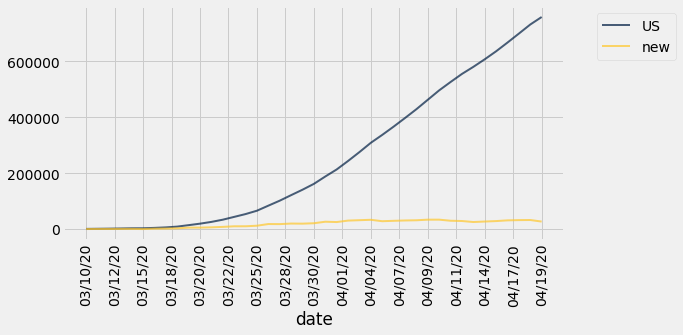

In [19]:
US_recent = US_case_trend.extract(['US', 'new']).after("03/10/20")
US_recent.oplot(width=8, xlab=20)

## Growth Rates

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

Since that time it has been dropping steadily as the measures became broader and more consistent.  While still way to fast for the health care systems to manage, it the difference is immense.  At 17% dailey, the number of cases grows by an order of magnitude over two weeks, instead of one,

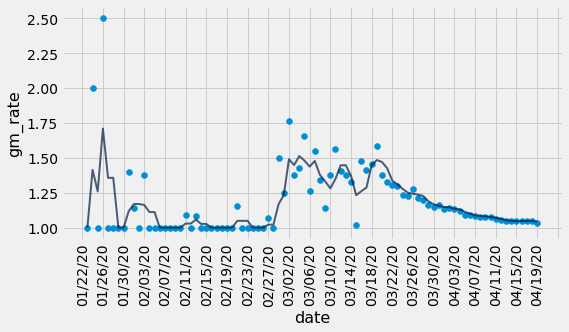

In [20]:
plot_rate_trend(US_case_trend)

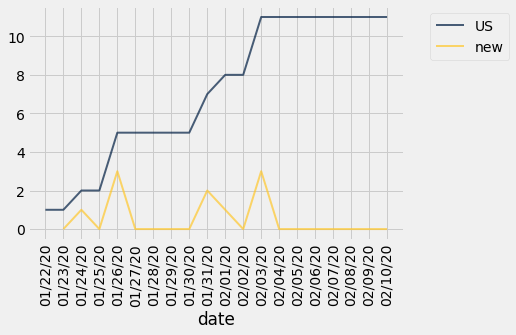

In [21]:
# Three weeks of early warning
US_case_trend.extract(['US', 'new']).before("02/10/20").oplot()

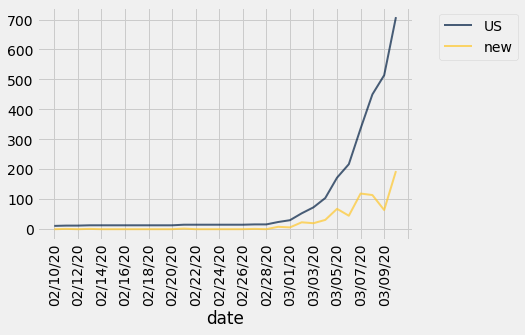

In [22]:
# The lost month
US_case_trend.extract(['US', 'new']).after("02/10/20").before("03/10/20").oplot(xlab=20)

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

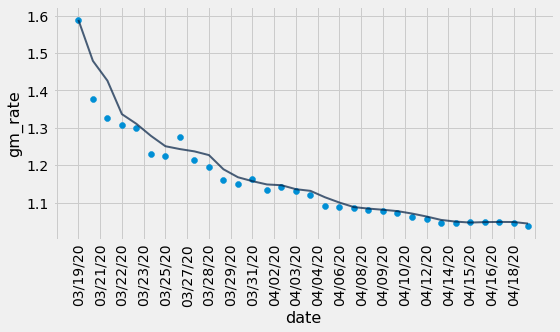

In [23]:
# Past month
plot_rate_trend(US_case_trend.tail(31))

Taking just the past two week, we can get a good fit.  What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  The trends are so slow that we need to go out two months (an eternity) to see a notable difference.

[1.08955759 0.99631971] [ 1.08926316 -0.00390452]


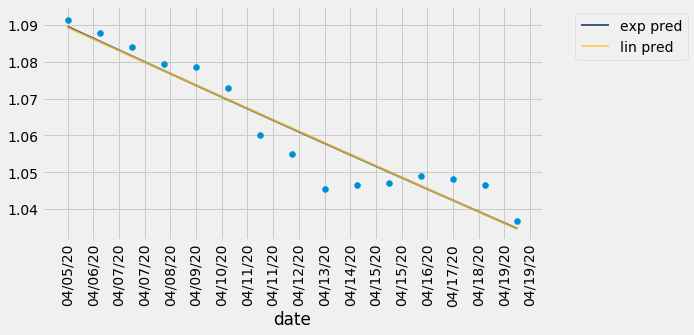

In [24]:
show_model_rate_trend(US_case_trend.tail(14))

In [25]:
US_rate_proj, eparams, lparams = model_rate_trend(US_case_trend.tail(14))

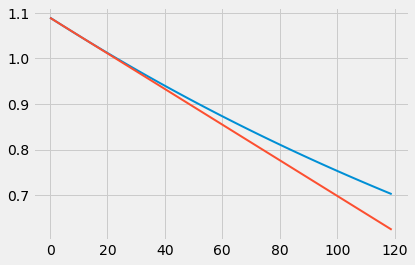

In [26]:
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(120)

## National Projections

Given some predictability, we can project grow rates into the future.  First we look projecting based on the current daily growth rate, modeling what things look like if we do just what we are seeing today, versus how they looked based on what we were seeing some days previously.

Then, given the steady reduction in rates, we project based on projecting the rate improving exponentially.

In [27]:
# Prediction going forward assuming the growth rate remains as it is currently

def proj_US(prev=2, dist=14):
    proj2(US_cases, 'US', prev, dist)
    
_ = interact(proj_US, prev=(0,7,1), dist = (3, 21, 1))

interactive(children=(IntSlider(value=2, description='prev', max=7), IntSlider(value=14, description='dist', m…

In [28]:
def project_progressive_trend(trend, region, num_days):
    day = trend.last(trend.time_column)
    val = trend.last(region)
    new = trend.last('new')
    rate = trend.last('rate')
    params, pcov = fit(exp_rate, trend)
    growths = exp_rate(range(num_days+1), rate, params[1])
    
    proj = trend.select([trend.time_column, region, 'new', 'rate'])
    for i in range(num_days):
        day = inc_day(day)
        rate = growths[i+1]
        new = rate*new
        val = val + new
        pnew = new/val
        proj.append((day, val, new, rate))
    return proj

def proj_prog(ts, region, prev=7, dist=14):
    trend = ts.trend().tail(prev)
    proj = project_progressive_trend(trend, region, dist)
    pproj = proj.select([proj.time_column, region, 'new']).tail(prev+dist)
    pproj.oplot(xlab=20, width = 8, height=6)
    end = trend.last(trend.time_column)
    plots.plot([end, end], [0, trend.last(region)])
    plots.text(end, trend.last(region), "{:,}".format(trend.last(region)))
    plots.text(pproj.last('date'), pproj.last(region), "{:,}".format(int(pproj.last(region))))

In [29]:
def pproj_US(prev=14, dist=14):
    proj_prog(US_cases, 'US', prev, dist)
    
_ = interact(pproj_US, prev=(0,14,1), dist = (3, 45, 1))



interactive(children=(IntSlider(value=14, description='prev', max=14), IntSlider(value=14, description='dist',…

In [30]:
project_progressive_trend(US_cases.trend().tail(7), 'US', 14).show()

date,US,new,rate
04/12/20,555313,28917,1.05493
04/13/20,580619,25306,1.04557
04/14/20,607670,27051,1.04659
04/15/20,636350,28680,1.0472
04/16/20,667592,31242,1.0491
04/17/20,699706,32114,1.0481
04/18/20,732197,32491,1.04644
04/19/20,759086,26889,1.03672
04/20/20,786926,27839.5,1.03535
04/21/20,815711,28785.4,1.03398


<a id=sectionCases></a>
## Cases to date by state

The following shows the national picture built up state by state.  Only the largest are shown, with the remainder
grouped into 'other'.

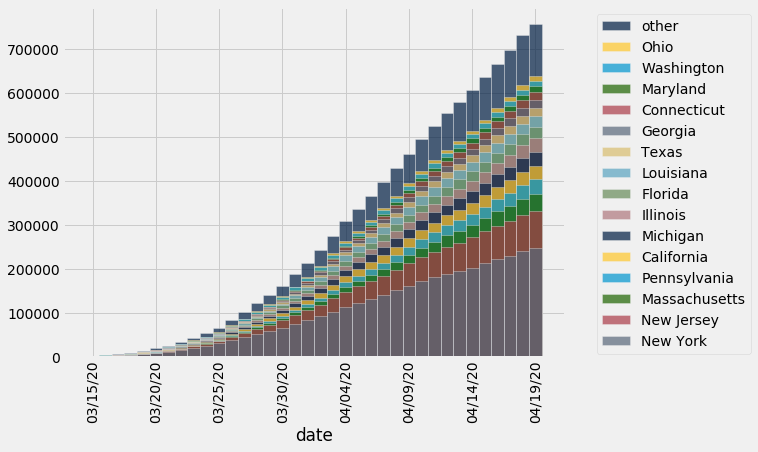

In [31]:
# Total US cases broken down by state
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

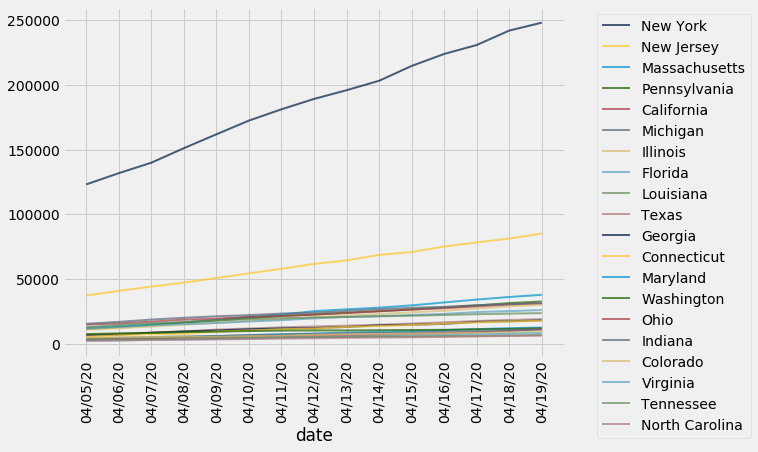

In [32]:
# Cases by state over the past two weeks
cases.top(20).tail(14).oplot(width=8, height=6)

In [33]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, limit=None, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            if limit :
                vals = vals[:limit]
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

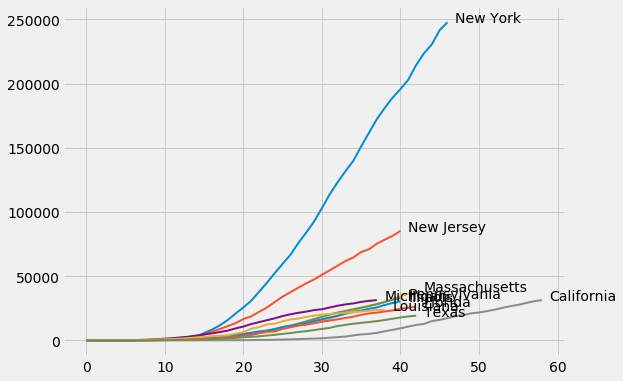

In [34]:
show_cases_since(cases.top(10), 10)

How have states handled the early community spread?  What does the month after reaching a significant number of cases look like?

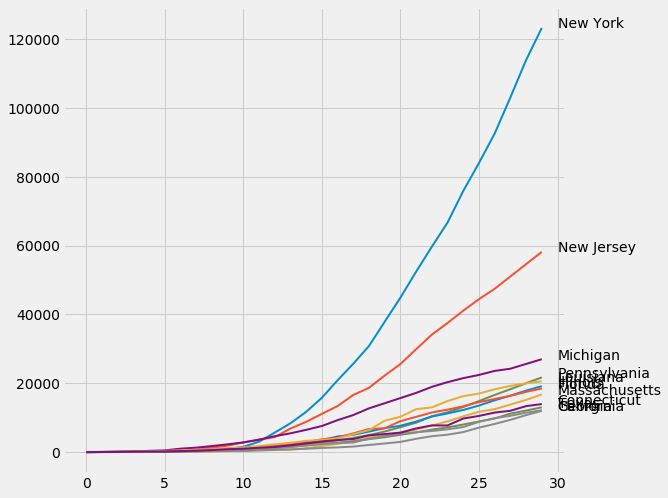

In [35]:
show_cases_since(cases.top(12), 40, 30, height=8)

In [36]:
def norm_by_population(ts):
    """Normalize region counts by population in percent"""
    normed = ts.select(ts.time_column)
    for region in ts.categories :
        if population(region) :
            normed[region] = 100*ts[region]/population(region)
    return normed

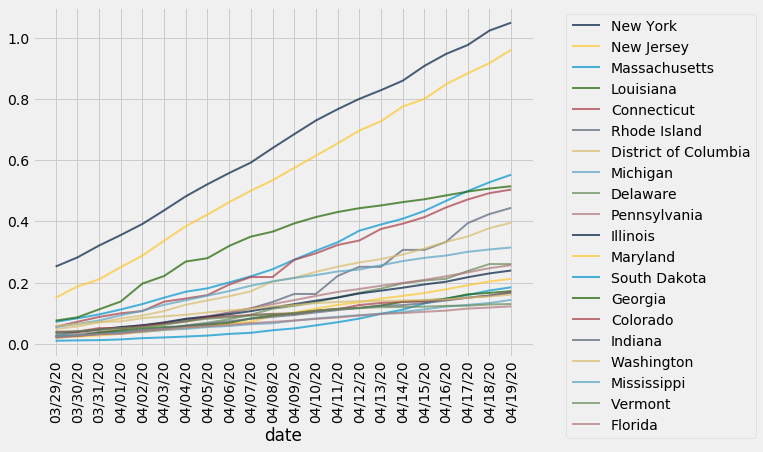

In [37]:
norm_by_population(cases).tail(21).top(20).oplot(height=6, width=8)

<a id='sectionTrends'></a>
## Growth trends by state

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [38]:
cases.order_cols().trend().tail(7)

date,New York,new New York,%new New York,rate New York,active New York,arate New York,New Jersey,new New Jersey,%new New Jersey,rate New Jersey,active New Jersey,arate New Jersey,Massachusetts,new Massachusetts,%new Massachusetts,rate Massachusetts,active Massachusetts,arate Massachusetts,Pennsylvania,new Pennsylvania,%new Pennsylvania,rate Pennsylvania,active Pennsylvania,arate Pennsylvania,California,new California,%new California,rate California,active California,arate California,Michigan,new Michigan,%new Michigan,rate Michigan,active Michigan,arate Michigan,Illinois,new Illinois,%new Illinois,rate Illinois,active Illinois,arate Illinois,Florida,new Florida,%new Florida,rate Florida,active Florida,arate Florida,Louisiana,new Louisiana,%new Louisiana,rate Louisiana,active Louisiana,arate Louisiana,Texas,new Texas,%new Texas,rate Texas,active Texas,arate Texas,Georgia,new Georgia,%new Georgia,rate Georgia,active Georgia,arate Georgia,Connecticut,new Connecticut,%new Connecticut,rate Connecticut,active Connecticut,arate Connecticut,Maryland,new Maryland,%new Maryland,rate Maryland,active Maryland,arate Maryland,Washington,new Washington,%new Washington,rate Washington,active Washington,arate Washington,Ohio,new Ohio,%new Ohio,rate Ohio,active Ohio,arate Ohio,Indiana,new Indiana,%new Indiana,rate Indiana,active Indiana,arate Indiana,Colorado,new Colorado,%new Colorado,rate Colorado,active Colorado,arate Colorado,Virginia,new Virginia,%new Virginia,rate Virginia,active Virginia,arate Virginia,Tennessee,new Tennessee,%new Tennessee,rate Tennessee,active Tennessee,arate Tennessee,North Carolina,new North Carolina,%new North Carolina,rate North Carolina,active North Carolina,arate North Carolina,Missouri,new Missouri,%new Missouri,rate Missouri,active Missouri,arate Missouri,Arizona,new Arizona,%new Arizona,rate Arizona,active Arizona,arate Arizona,Alabama,new Alabama,%new Alabama,rate Alabama,active Alabama,arate Alabama,Rhode Island,new Rhode Island,%new Rhode Island,rate Rhode Island,active Rhode Island,arate Rhode Island,South Carolina,new South Carolina,%new South Carolina,rate South Carolina,active South Carolina,arate South Carolina,Wisconsin,new Wisconsin,%new Wisconsin,rate Wisconsin,active Wisconsin,arate Wisconsin,Mississippi,new Mississippi,%new Mississippi,rate Mississippi,active Mississippi,arate Mississippi,Nevada,new Nevada,%new Nevada,rate Nevada,active Nevada,arate Nevada,Utah,new Utah,%new Utah,rate Utah,active Utah,arate Utah,Kentucky,new Kentucky,%new Kentucky,rate Kentucky,active Kentucky,arate Kentucky,Iowa,new Iowa,%new Iowa,rate Iowa,active Iowa,arate Iowa,District of Columbia,new District of Columbia,%new District of Columbia,rate District of Columbia,active District of Columbia,arate District of Columbia,Oklahoma,new Oklahoma,%new Oklahoma,rate Oklahoma,active Oklahoma,arate Oklahoma,Delaware,new Delaware,%new Delaware,rate Delaware,active Delaware,arate Delaware,Minnesota,new Minnesota,%new Minnesota,rate Minnesota,active Minnesota,arate Minnesota,Oregon,new Oregon,%new Oregon,rate Oregon,active Oregon,arate Oregon,Kansas,new Kansas,%new Kansas,rate Kansas,active Kansas,arate Kansas,New Mexico,new New Mexico,%new New Mexico,rate New Mexico,active New Mexico,arate New Mexico,Arkansas,new Arkansas,%new Arkansas,rate Arkansas,active Arkansas,arate Arkansas,Idaho,new Idaho,%new Idaho,rate Idaho,active Idaho,arate Idaho,South Dakota,new South Dakota,%new South Dakota,rate South Dakota,active South Dakota,arate South Dakota,Nebraska,new Nebraska,%new Nebraska,rate Nebraska,active Nebraska,arate Nebraska,New Hampshire,new New Hampshire,%new New Hampshire,rate New Hampshire,active New Hampshire,arate New Hampshire,Puerto Rico,new Puerto Rico,%new Puerto Rico,rate Puerto Rico,active Puerto Rico,arate Puerto Rico,West Virginia,new West Virginia,%new West Virginia,rate West Virginia,active West Virginia,arate West Virginia,Maine,new Maine,%new Maine,rate Maine,active Maine,arate Maine,Vermont,new Vermont,%new Verm

In [39]:
def rate_change(ts, region_type, prev=7):
    rates   = get_rates(ts)
    regions = ts.categories
    current = rates.row(-1)[1:]
    older   = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous.  The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse.  Gives a sense of how the measures are working.

In [40]:
def irate(previous=7):
    show_rate_change(cases, 'State', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by state

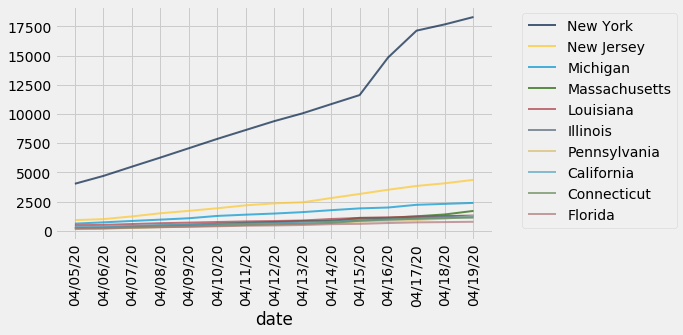

In [41]:
deaths.top(10).tail(14).oplot(width=7)

In [42]:
deaths.order_cols().trend().tail(7)

date,New York,new New York,%new New York,rate New York,active New York,arate New York,New Jersey,new New Jersey,%new New Jersey,rate New Jersey,active New Jersey,arate New Jersey,Michigan,new Michigan,%new Michigan,rate Michigan,active Michigan,arate Michigan,Massachusetts,new Massachusetts,%new Massachusetts,rate Massachusetts,active Massachusetts,arate Massachusetts,Louisiana,new Louisiana,%new Louisiana,rate Louisiana,active Louisiana,arate Louisiana,Illinois,new Illinois,%new Illinois,rate Illinois,active Illinois,arate Illinois,Pennsylvania,new Pennsylvania,%new Pennsylvania,rate Pennsylvania,active Pennsylvania,arate Pennsylvania,California,new California,%new California,rate California,active California,arate California,Connecticut,new Connecticut,%new Connecticut,rate Connecticut,active Connecticut,arate Connecticut,Florida,new Florida,%new Florida,rate Florida,active Florida,arate Florida,Georgia,new Georgia,%new Georgia,rate Georgia,active Georgia,arate Georgia,Washington,new Washington,%new Washington,rate Washington,active Washington,arate Washington,Indiana,new Indiana,%new Indiana,rate Indiana,active Indiana,arate Indiana,Texas,new Texas,%new Texas,rate Texas,active Texas,arate Texas,Ohio,new Ohio,%new Ohio,rate Ohio,active Ohio,arate Ohio,Maryland,new Maryland,%new Maryland,rate Maryland,active Maryland,arate Maryland,Colorado,new Colorado,%new Colorado,rate Colorado,active Colorado,arate Colorado,Virginia,new Virginia,%new Virginia,rate Virginia,active Virginia,arate Virginia,Wisconsin,new Wisconsin,%new Wisconsin,rate Wisconsin,active Wisconsin,arate Wisconsin,North Carolina,new North Carolina,%new North Carolina,rate North Carolina,active North Carolina,arate North Carolina,Missouri,new Missouri,%new Missouri,rate Missouri,active Missouri,arate Missouri,Arizona,new Arizona,%new Arizona,rate Arizona,active Arizona,arate Arizona,Mississippi,new Mississippi,%new Mississippi,rate Mississippi,active Mississippi,arate Mississippi,Nevada,new Nevada,%new Nevada,rate Nevada,active Nevada,arate Nevada,Alabama,new Alabama,%new Alabama,rate Alabama,active Alabama,arate Alabama,Rhode Island,new Rhode Island,%new Rhode Island,rate Rhode Island,active Rhode Island,arate Rhode Island,Tennessee,new Tennessee,%new Tennessee,rate Tennessee,active Tennessee,arate Tennessee,Kentucky,new Kentucky,%new Kentucky,rate Kentucky,active Kentucky,arate Kentucky,Oklahoma,new Oklahoma,%new Oklahoma,rate Oklahoma,active Oklahoma,arate Oklahoma,Minnesota,new Minnesota,%new Minnesota,rate Minnesota,active Minnesota,arate Minnesota,South Carolina,new South Carolina,%new South Carolina,rate South Carolina,active South Carolina,arate South Carolina,District of Columbia,new District of Columbia,%new District of Columbia,rate District of Columbia,active District of Columbia,arate District of Columbia,Kansas,new Kansas,%new Kansas,rate Kansas,active Kansas,arate Kansas,Iowa,new Iowa,%new Iowa,rate Iowa,active Iowa,arate Iowa,Oregon,new Oregon,%new Oregon,rate Oregon,active Oregon,arate Oregon,Delaware,new Delaware,%new Delaware,rate Delaware,active Delaware,arate Delaware,Puerto Rico,new Puerto Rico,%new Puerto Rico,rate Puerto Rico,active Puerto Rico,arate Puerto Rico,New Mexico,new New Mexico,%new New Mexico,rate New Mexico,active New Mexico,arate New Mexico,Idaho,new Idaho,%new Idaho,rate Idaho,active Idaho,arate Idaho,Arkansas,new Arkansas,%new Arkansas,rate Arkansas,active Arkansas,arate Arkansas,New Hampshire,new New Hampshire,%new New Hampshire,rate New Hampshire,active New Hampshire,arate New Hampshire,Vermont,new Vermont,%new Vermont,rate Vermont,active Vermont,arate Vermont,Maine,new Maine,%new Maine,rate Maine,active Maine,arate Maine,Nebraska,new Nebraska,%new Nebraska,rate Nebraska,active Nebraska,arate Nebraska,Utah,new Utah,%new Utah,rate Utah,active Utah,arate Utah,West Virginia,new West Virginia,%new West Virginia,rate West Virginia,active West Virginia,arate West Virginia,Hawaii,new Hawaii,%new Hawaii,rate Hawaii,active Hawaii,ara

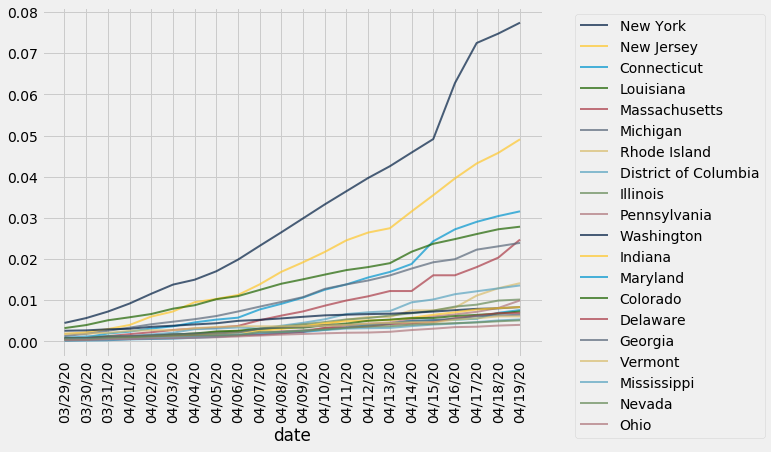

In [43]:
norm_by_population(deaths).tail(21).top(20).oplot(height=6, width=8)

<a id='sectionOneState'></a>
## Cases in one state

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [44]:
def show_st(state='California', prev = 7):
    cases.extract(state).trend().tail(prev).show()
    cases.extract(state).trend().extract([state, 'new']).tail(21).oplot(width=7)
    plot_rate_trend(cases.extract(state).trend().tail(prev))

_ = interact(show_st, state=states, prev = (7, 21, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

<a id='sectionProj'></a>
## Projection of cases in one state

To look forward at what the story may be over the coming days, we project forward the recent growth rate.  This may be pessimistic if measures are working and the rate is improving.  But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.

In [45]:
def proj_st(state='California', dist=14):
    proj(cases, state, 7, dist)
    
_ = interact(proj_st, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

In [46]:
def proj_prog_st(state='California', dist=14):
    proj_prog(cases.extract(state), state, 7, dist)
    
_ = interact(proj_prog_st, state=states, dist = (7, 31, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

<a id='sectionProjDeath'></a>
## Projection of deaths in one state

In [47]:
def proj_st_deaths(state='California', dist=14):
    proj(deaths, state, 7, dist)

_ = interact(proj_st_deaths, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [48]:
def proj2_st(state='California', prev=2, dist=14):
    proj2(cases, state, prev, dist)
    
_ = interact(proj2_st, state=states, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

In [49]:
def proj2_st_deaths(state='California', prev=2):
    proj2(deaths, state, prev)
    
_ = interact(proj2_st_deaths, state=states, prev=(0,7,1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [50]:
get_rates(cases).tail(7)

date,Alabama,Alabama,Alaska,Alaska,American Samoa,American Samoa,Arizona,Arizona,Arkansas,Arkansas,California,California,Colorado,Colorado,Connecticut,Connecticut,Delaware,Delaware,Diamond Princess,Diamond Princess,District of Columbia,District of Columbia,Florida,Florida,Georgia,Georgia,Grand Princess,Grand Princess,Guam,Guam,Hawaii,Hawaii,Idaho,Idaho,Illinois,Illinois,Indiana,Indiana,Iowa,Iowa,Kansas,Kansas,Kentucky,Kentucky,Louisiana,Louisiana,Maine,Maine,Maryland,Maryland,Massachusetts,Massachusetts,Michigan,Michigan,Minnesota,Minnesota,Mississippi,Mississippi,Missouri,Missouri,Montana,Montana,Nebraska,Nebraska,Nevada,Nevada,New Hampshire,New Hampshire,New Jersey,New Jersey,New Mexico,New Mexico,New York,New York,North Carolina,North Carolina,North Dakota,North Dakota,Northern Mariana Islands,Northern Mariana Islands,Ohio,Ohio,Oklahoma,Oklahoma,Oregon,Oregon,Pennsylvania,Pennsylvania,Puerto Rico,Puerto Rico,Rhode Island,Rhode Island,South Carolina,South Carolina,South Dakota,South Dakota,Tennessee,Tennessee,Texas,Texas,Utah,Utah,Vermont,Vermont,Virgin Islands,Virgin Islands,Virginia,Virginia,Washington,Washington,West Virginia,West Virginia,Wisconsin,Wisconsin,Wyoming,Wyoming
04/12/20,1.10755,0.1206,1.05837,0.0802139,nan,nan,1.04391,0.05381,1.04235,0.0597015,1.05017,0.0615254,1.12191,0.142626,1.04561,0.0499477,1.09872,0.103473,1,nan,1.05456,0.0617441,1.07575,0.086846,1.0241,0.0290502,1,nan,1,0,1.07312,0.0971429,1.00788,0.00937766,1.08717,0.0963078,1.06631,0.073637,1.05099,0.0597362,1.05412,0.0640074,1.15948,0.170562,1.02903,0.0336227,1.0276,0.0402844,1.06901,0.073444,1.11439,0.123244,1.02707,0.032612,1.13595,0.164407,1.05261,0.065628,1.03919,0.0468978,1.02653,0.0387597,1.13162,0.132374,1.04959,0.0606335,1.04972,0.0592992,1.06361,0.0729212,1.14115,0.148505,1.04423,0.0586065,1.04961,0.0608451,1.05119,0.0700935,1,0,1.05664,0.0681031,1.0546,0.0640301,1.11379,0.148855,1.05613,0.0606679,1.13832,0.136763,1.13453,0.130256,1.03395,0.0409774,1.16613,0.1571,1.07327,0.0940706,1.05022,0.0582784,1.0435,0.0564374,1.0225,0.0310078,1,0,1.0388,0.0434495,1.01677,0.0265998,1.02773,0.0321932,1.03984,0.055993,1.03448,0.0478723
04/13/20,1.04799,0.0587831,1.01838,0.0285714,nan,nan,1.04602,0.0585068,1.10156,0.132114,1.04984,0.0628353,1.05255,0.0713224,1.11184,0.118195,1.08185,0.087156,1,nan,1.04267,0.049597,1.0565,0.0670125,1.06931,0.0809265,1,nan,1,0,1.01002,0.0140845,1.0135,0.0165939,1.05625,0.0673016,1.05436,0.0629565,1.0775,0.0895197,1.03423,0.0433962,1.02802,0.0348101,1.02044,0.0240902,1.10269,0.146067,1.08644,0.0923737,1.05464,0.0635268,1.05738,0.0690425,1,0,1.05789,0.0737517,1.05762,0.0683333,1.01809,0.0291667,1.02908,0.0325779,1.0543,0.0743961,1.06028,0.0726329,1.0442,0.0534005,1.01365,0.0165854,1.03553,0.0493457,1.06915,0.085521,1.07468,0.0987124,1,0,1.05618,0.0697106,1.05025,0.0603659,1.03733,0.0550193,1.05903,0.0649089,1.00669,0.00773196,1,0,1.02139,0.0271303,1.18904,0.177378,1.01852,0.0262211,1.04372,0.052077,1.02605,0.0365186,1.02889,0.0409357,1,0,1.08969,0.0973852,1.00245,0.00421394,1.03035,0.0361446,1.02604,0.0384276,1.01852,0.026455
04/14/20,1.05865,0.0717092,1.02888,0.0467836,nan,nan,1.02807,0.0392157,1.06241,0.0858537,1.05955,0.0782193,1.03368,0.0459301,1.04544,0.0532493,1.09556,0.101083,1,nan,1.05269,0.0621605,1.02897,0.0376973,1.09486,0.107307,1,nan,1,0,1.01389,0.0208333,1.02665,0.0338078,1.05553,0.0672274,1.0201,0.0249221,1.11053,0.128136,1.03669,0.0477081,1.01487,0.0191205,1.02389,0.0286972,1.05301,0.0804348,1.05998,0.0665095,1.04827,0.0578708,1.05329,0.0666244,1.04565,0.0661305,1.04929,0.0647321,1.05116,0.0625169,1.01269,0.0219298,1.10197,0.110372,1.04816,0.0678605,0.936041,-0.103618,1.06565,0.0812447,1.06577,0.0749097,1.03714,0.0533233,1.04646,0.0597368,1.03021,0.0431034,1,0,1.04444,0.0579223,1.05558,0.0675279,1.03093,0.0477118,1.04829,0.0550446,1.02215,0.0267023,1.21989,0.20612,1.04777,0.0616438,1.13825,0.135287,1.03868,0.0554987,1.05121,0.0616409,1.02285,0.0333539,1.00535,0.00806452,1,0,1.07569,0.0842697,1.01542,0.0279101

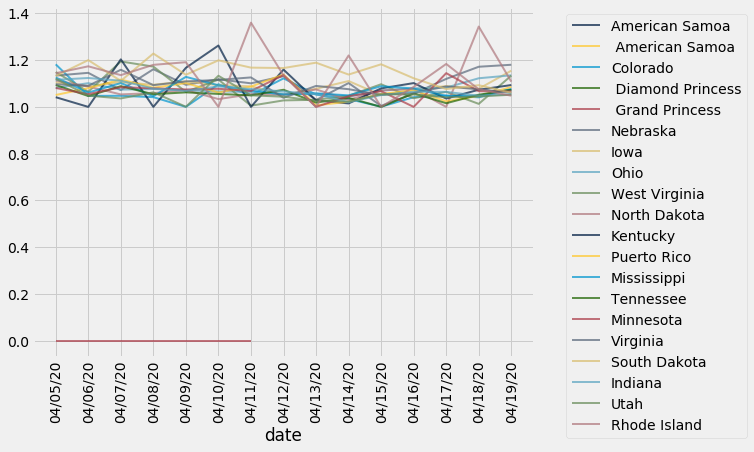

In [51]:
get_rates(cases).tail(14).top(20).oplot(height=6, width=8)

/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


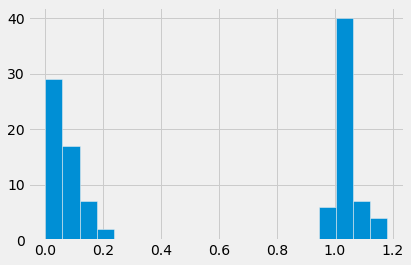

In [52]:
_ = plots.hist(get_rates(cases).take[-1].row(0)[1:], bins=20)

In [53]:
def best_rate(ts, n):
    rates = get_rates(ts).tail(7).order_cols()
    best = rates.labels[-n:]
    return rates.extract(best)

In [54]:
best_rate(cases, 12)

date,Arkansas,Alaska,Connecticut,Wyoming,Louisiana,Vermont,Hawaii,Idaho,Delaware,Guam,Northern Mariana Islands,Virgin Islands
04/12/20,0.0597015,0.0802139,0.0499477,0.0478723,0.0336227,0.0310078,0.0971429,0.00937766,0.103473,0,0,0
04/13/20,0.132114,0.0285714,0.118195,0.026455,0.0240902,0.0409357,0.0140845,0.0165939,0.087156,0,0,0
04/14/20,0.0858537,0.0467836,0.0532493,0.037234,0.0286972,0.00806452,0.0208333,0.0338078,0.101083,0,0,0
04/15/20,0.0678776,0.045977,0.0658811,0.0280899,0.0259064,0.0150215,0.040625,0.00939457,0.0519174,0.030303,0.181818,0
04/16/20,0.0492278,0.0416667,0.0915876,0.0542169,0.036069,0.0331126,0.0196078,0.111655,0.0329025,0,0,0
04/17/20,0.0712928,0.0542169,0.071236,0.0580645,0.04195,0.0113379,0.0385965,0.0264106,0.128378,0.0185185,0,0
04/18/20,0.0471154,0.0318471,0.058642,0.0272109,0.0347813,0.057971,0.129412,0.0602094,0.105843,0,0.166667,0.125
04/19/20,0.0356455,0.0337838,0.0324767,0.031746,0.0304409,0.0284091,0.0262009,0.0201238,0,0,0,0


In [55]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def get_rate_slope(trend, region):
    params, pcov = fit(lin_rate, trend)
    return params[1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions],
    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff rate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err']))

In [56]:
case_sum = summary(cases, 'state', states)
case_sum.sort('delta', descending=True)

/Users/culler/anaconda3/envs/data8/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


state,current,new,rate,eff rate,delta,err
North Dakota,585,57,1.10795,1.02528,0.0197285,0.0156943
Nebraska,1474,225,1.18014,1.05115,0.0137875,0.00913037
Ohio,11602,1380,1.135,1.03901,0.0119435,0.00228461
Iowa,2902,389,1.1548,1.05697,0.00816488,0.00459975
West Virginia,890,105,1.13376,1.0294,0.00769521,0.00599242
Washington,12255,479,1.04068,1.00609,0.00408725,0.00163369
Utah,3069,152,1.05211,1.03359,0.00244303,0.00172601
Northern Mariana Islands,14,0,1,1.02389,0.00241425,0.0109765
Virgin Islands,53,0,1,0.996732,0.00233427,0.00210516
Kansas,1905,84,1.04613,1.0445,0.00201887,0.00229713


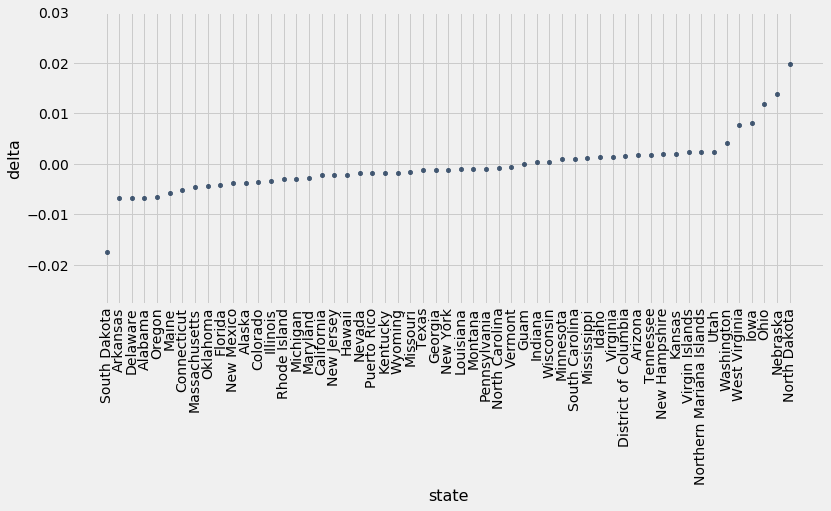

In [57]:
case_sum.select('state', 'delta').sort('delta').scatter('state', width=12)
_ = plots.xticks(rotation=90)

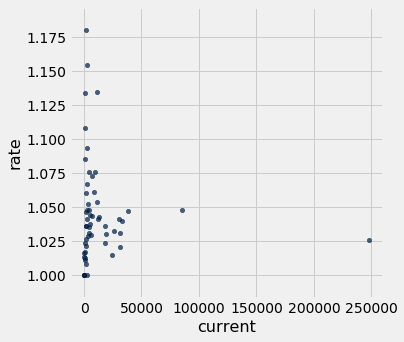

In [58]:
case_sum.scatter('current', 'rate')

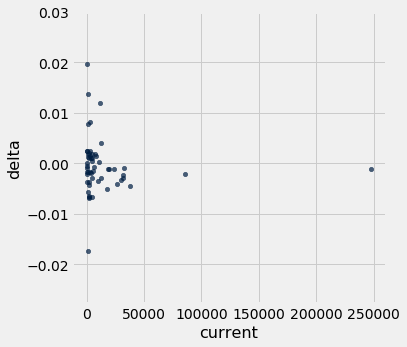

In [59]:
case_sum.scatter('current', 'delta')

## Risk 

In [60]:
case_sum

state,current,new,rate,eff rate,delta,err
Alabama,4888,176,1.03735,1.07734,-0.00668646,0.00318147
Alaska,319,5,1.01592,1.04033,-0.00367765,0.00172677
Arizona,4933,209,1.04424,1.04187,0.00174122,0.00206249
Arkansas,1781,37,1.02122,1.07176,-0.00683827,0.00313051
California,31431,940,1.03083,1.05529,-0.00225407,0.00124857
Colorado,9730,683,1.07549,1.06432,-0.00353013,0.00567663
Connecticut,17962,412,1.02348,1.07556,-0.0051618,0.00389749
Delaware,2538,0,1,1.09429,-0.0067849,0.00630916
District of Columbia,2793,127,1.04764,1.05285,0.00150967,0.00187247
Florida,26314,822,1.03225,1.05968,-0.00414077,0.00230717


In [61]:
US_sum = case_sum.join('state', states_population, 'State')
US_sum['case_per_k'] = 1000*US_sum['current']/US_sum['Population']
US_sum['risk'] = US_sum['rate'] * US_sum['delta'] * US_sum['case_per_k']
US_sum = US_sum.sort('risk', descending=True)
US_sum

state,current,new,rate,eff rate,delta,err,Population,case_per_k,risk
North Dakota,585,57,1.10795,1.02528,0.0197285,0.0156943,762062,0.767654,0.0167796
Ohio,11602,1380,1.135,1.03901,0.0119435,0.00228461,11689100,0.992549,0.0134548
Nebraska,1474,225,1.18014,1.05115,0.0137875,0.00913037,1934408,0.76199,0.0123985
Iowa,2902,389,1.1548,1.05697,0.00816488,0.00459975,3155070,0.919789,0.00867248
Washington,12255,479,1.04068,1.00609,0.00408725,0.00163369,7614893,1.60935,0.00684536
District of Columbia,2793,127,1.04764,1.05285,0.00150967,0.00187247,705749,3.9575,0.00625914
West Virginia,890,105,1.13376,1.0294,0.00769521,0.00599242,1792147,0.496611,0.00433269
Utah,3069,152,1.05211,1.03359,0.00244303,0.00172601,3205958,0.95728,0.00246053
Tennessee,7070,481,1.073,1.03471,0.00184688,0.00452905,6829174,1.03526,0.00205158
New Hampshire,1390,48,1.03577,1.05452,0.00191621,0.0148314,1359711,1.02228,0.00202896


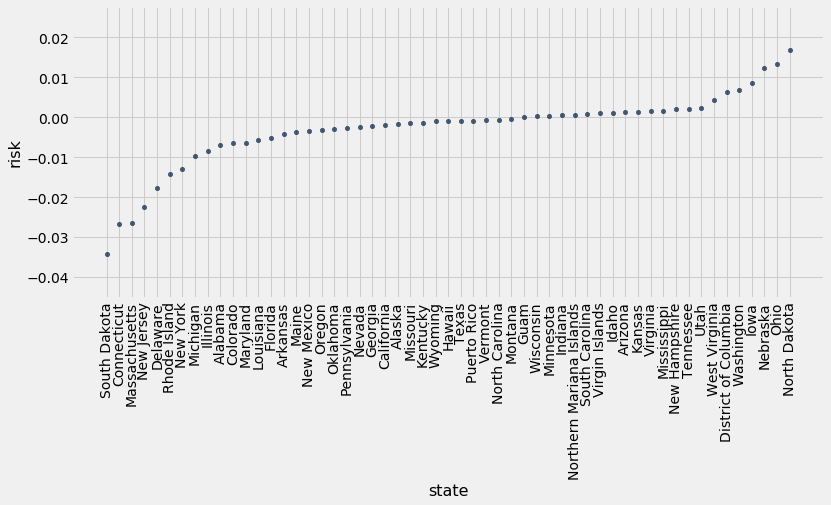

In [62]:
US_sum.select('state', 'risk').sort('risk').scatter('state', width=12)
_ = plots.xticks(rotation=90)

In [63]:
def show_rst(vstate, prev=14, dist=21):
    vtrend = cases.extract(vstate).trend()
    vtrend.tail(prev).show()
    norm_by_population(cases).extract(vstate).trend().extract([vstate, 'new']).tail(21).oplot(width=7)
    plot_rate_trend(vtrend.tail(prev))
    show_model_rate_trend(vtrend.tail(14))
    proj_prog(cases.extract(vstate), vstate, prev, dist)
    
interact(show_rst, vstate=US_sum['state'])

interactive(children=(Dropdown(description='vstate', options=('North Dakota', 'Ohio', 'Nebraska', 'Iowa', 'Was…

<function __main__.show_rst(vstate, prev=14, dist=21)>